In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from tqdm import tqdm_notebook
import scipy.integrate as integrate
import copy
import seaborn as sns
from pathlib import Path

In [74]:
MODEL_DIRECTORY = Path('../model/')
MAIN_DIRECTORY = Path('../')

In [77]:
def read_file(filename):
    df = pd.read_csv(filename, delimiter='\\s+')
    df = df.apply(pd.to_numeric, errors='coerce')
    try:
        df.dropna(subset = ['phot_g_mean_mag','bp_rp'], inplace = True)
    except:
        pass
    return df

In [78]:
singles_data = read_file(MODEL_DIRECTORY / 'model_separated_singles_250pc_manystars_flat.txt')
singles_data = singles_data[singles_data['bp-rp, mag']>0]

In [79]:
binaries_data = read_file(MODEL_DIRECTORY / 'model_separated_binaries_250pc_manystars_flat.txt')
binaries_data = binaries_data[binaries_data['bp-rp, mag']>0]

In [80]:
singles_data['g, mag'].min()

8.39778944291929

## last cleaning

In [81]:
degree = 17
popt = np.polyfit(singles_data['bp-rp, mag'], singles_data['g, mag'], degree)
func_iso = np.poly1d(popt)

isochrone = pd.DataFrame(data = {'bp-rp, mag' : np.linspace(singles_data['bp-rp, mag'].min()-0.05, 
                                                       singles_data['bp-rp, mag'].max()+0.05, 500)})

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  


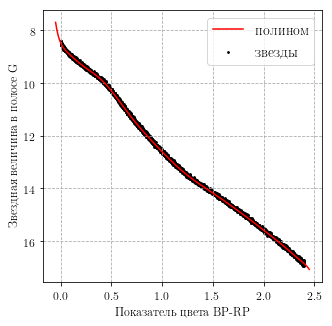

In [82]:
fig, ax = plt.subplots(figsize=(5,5 ))
ax.scatter (singles_data['bp-rp, mag'] , singles_data['g, mag'] , c ='black', s = 3, label ='звезды')
ax.plot(isochrone['bp-rp, mag'],func_iso(isochrone['bp-rp, mag']) , c ='red', lw = 1.5, label ='полином') 
ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()
ax.invert_yaxis()

plt.rcParams.update({'font.size': 12})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[russian]{babel}')

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')
ax.legend(fontsize = 15)
plt.savefig("polynomial_approximation.pdf", bbox_inches = 'tight')
plt.show()

In [83]:
degree = 15
popt = np.polyfit(singles_data['bp-rp, mag'], singles_data['g, mag'], degree)
func_iso = np.poly1d(popt)

isochrone = pd.DataFrame(data = {'bp-rp, mag' : np.linspace(singles_data['bp-rp, mag'].min()-0.05, 
                                                       singles_data['bp-rp, mag'].max()+0.05, 500)})

singles_data['Gmag_new'] = singles_data['g, mag'] - func_iso(singles_data['bp-rp, mag'])
binaries_data['Gmag_new'] = binaries_data['g, mag'] - func_iso(binaries_data['bp-rp, mag'])

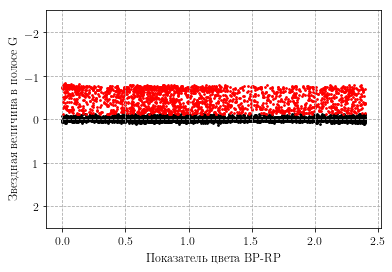

In [84]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter (singles_data['bp-rp, mag'] , singles_data['Gmag_new'] , c ='black', s = 3, label ='звезды')
ax.scatter (binaries_data['bp-rp, mag'] , binaries_data['Gmag_new'] , c ='red', s = 3, label ='звезды')

ax.grid(c='#aaaaaa', ls='--') 
locs, labels = plt.yticks()
locs, labels = plt.xticks()

ax.set_ylim(-2.5,2.5)
ax.invert_yaxis()

plt.xlabel('Показатель цвета BP-RP')
plt.ylabel('Звездная величина в полосе G')
ax.tick_params(axis='both', which='major')
#ax.legend(fontsize = 15)
#plt.savefig("horizontal_sequence.pdf", bbox_inches = 'tight')
plt.show()

In [85]:
all_stars_data = pd.concat([binaries_data, singles_data])
#all_stars_data = all_stars_data[all_stars_data['bp-rp, mag']>0]

In [86]:
num_stars = len(all_stars_data)
profile = pd.DataFrame(data = {'x' : np.linspace(-2, 1, 701)})
kde = KernelDensity(kernel='epanechnikov', bandwidth=0.15)
kde.fit(all_stars_data[['Gmag_new']].to_numpy())

profile['density'] = np.exp(kde.score_samples(profile[['x']].to_numpy())) 
profile['density'] *= num_stars

Text(0.5, 0, '$G_{new}$')

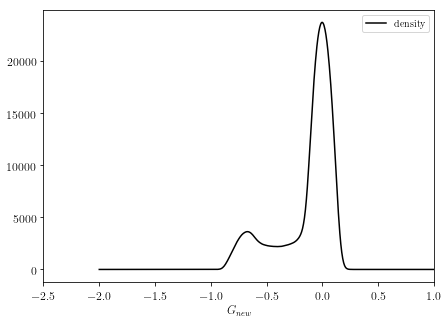

In [87]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(profile['x'], profile['density'], lw = 1.5, color = 'black')
ax.set_xlim(-2.5, 1)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel('$G_{new}$')

In [88]:
def f(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / c) + d

row_max = profile['density'].idxmax()
popt, pcov = curve_fit(f, profile.iloc[row_max-5:row_max+155, 0], profile.iloc[row_max-5:row_max+155, 1],
                           bounds=([0, profile.iloc[row_max, 0]-0.1, 0, -0.1],
                                   [30000, profile.iloc[row_max, 0]+0.1, 0.4, 0.1]),
                          maxfev=9000)

profile_gauss = pd.DataFrame(data={'x': profile['x']})
profile_gauss['density'] = f(profile_gauss['x'], *popt)

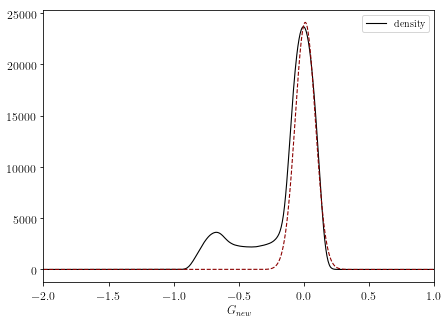

In [89]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(profile['x'], profile['density'], lw = 1.1, color = 'black')
ax.plot(profile_gauss['x'], profile_gauss['density'], lw = 1.1, ls='--', color='darkred', label='_nolabel')
ax.set_xlim(-2, 1)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel('$G_{new}$')
fig.savefig(f"model_profile_250pc_manystars_flat.pdf", bbox_inches = 'tight')

Text(0.5, 0, '$G_{new}$')

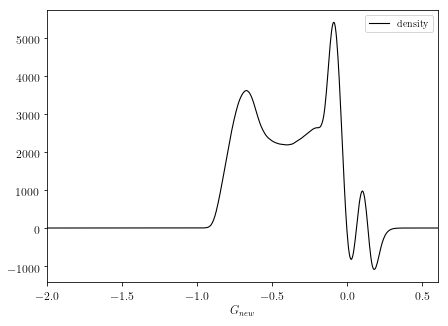

In [90]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(profile['x'], profile['density'] - profile_gauss['density'], lw = 1.1, color = 'black')
ax.set_xlim(-2, 0.6)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel('$G_{new}$')
#fig.savefig(f"{CLUSTER}_profile_binaries.pdf", bbox_inches = 'tight')

In [91]:
difference = profile['density'] - profile_gauss['density']
difference[difference < 0] = 0

number_of_multiples = int(integrate.trapz(difference, profile['x']))

In [92]:
# доля двойных из интегрирования профиля
number_of_multiples / len(all_stars_data)

0.34446195730047285

In [93]:
# доля двойных из "первичного отбора"
len(binaries_data) / (len(binaries_data) + len(singles_data))

0.27812007450924203

In [94]:
len(all_stars_data[(all_stars_data['Mass']>0) == False]) / len(all_stars_data)

0.5003582175096719

In [95]:
stars_left = binaries_data[binaries_data['bp-rp, mag'] < 0.75]
stars_centre = binaries_data[(binaries_data['bp-rp, mag'] < 1.5) & (binaries_data['bp-rp, mag'] > 0.75)]
stars_right = binaries_data[binaries_data['bp-rp, mag'] > 1.5]

q_left = stars_left['Mass2'] / stars_left['Mass1']
q_centre = stars_centre['Mass2'] / stars_centre['Mass1']
q_right = stars_right['Mass2'] / stars_right['Mass1']

q_absence = (singles_data['Mass2'] / singles_data['Mass1'])
q = binaries_data['Mass2'] / binaries_data['Mass1']

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


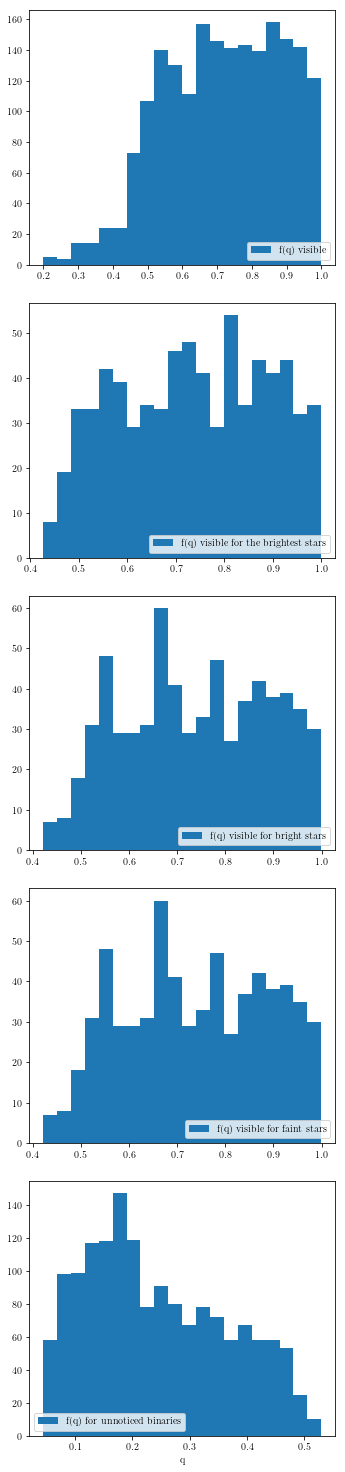

In [96]:
plt.figure(figsize=(5,15))
plt.rcParams.update({'font.size': 10})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble=r'\usepackage[english]{babel}')


plt.subplot(5, 1, 1)
plt.hist(q, bins=20, label=r'f(q) visible')
plt.legend(loc='lower right')

plt.subplot(5, 1, 2)
plt.hist(q_left, bins=20, label=r'f(q) visible for the brightest stars')
plt.legend(loc='lower right')

plt.subplot(5, 1, 3)
plt.hist(q_centre, bins=20, label=r'f(q) visible for bright stars')
plt.legend(loc='lower right')

plt.subplot(5, 1, 4)
plt.hist(q_centre, bins=20, label=r'f(q) visible for faint stars')
plt.legend(loc='lower right')

plt.subplot(5, 1, 5)
plt.hist(q_absence, bins=20, label=r'f(q) for unnoticed binaries')
plt.legend(loc='lower left')

plt.xlabel('q')

plt.subplots_adjust(top=1.4, bottom=0.08, left=0.10, right=0.95, hspace=0.15,wspace=0.2)
#plt.savefig("q_distribution_model_flat.pdf", bbox_inches = 'tight')